In [1]:
import numpy as np
from inference import inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def seir(X_t, t, theta, x_out=None):
    "SEIR ODE function"
    if x_out is None:
        x_out = np.empty(4)
    p = len(X_t)//4
    S, E, I, R = X_t[::p]
    N = S + E + I + R
    x_out[0] = -theta[0]*S*I/N
    x_out[1] = theta[0]*S*I/N - theta[1]*E
    x_out[2] = theta[1]*E - theta[2]*I
    x_out[3] = theta[2]*I
    return x_out

n_deriv = [1]*4 # number of derivatives in IVP
n_deriv_prior = [3]*4 # number of derivatives in IBM prior
state_ind = [0, 3, 6, 9] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0
tmax = 100

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 4
sigma = [.1]*n_var

# Initial value, x0, for the IVP
beta = np.random.uniform(0.01, 0.02)
delta = np.random.uniform(1/4, 1/2)
vega = np.random.uniform(1/2, 1)
theta_true = np.array([beta, delta, vega]) # True theta
x0 = np.array([999, 1, 0, 0])
v0 = seir(x0, 0, theta_true)
X0 = np.ravel([x0, v0], 'F')

# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

# logprior parameters
n_theta = len(theta_true)
phi_sd = np.ones(n_theta)

# Observation noise
gamma = 0.2

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, seir)
Y_t, _ = inf.simulate(seir, x0, theta_true, gamma)

# Parameter inference using Euler's approximation
hlst = np.array([0.1])
theta_euler = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    phi_hat, phi_var = inf.phi_fit(Y_t, x0, hlst[i], theta_true, phi_sd, gamma, False)
    theta_euler[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
np.save('saves/seir_theta_euler.npy', theta_euler)

# Parameter inference using Kalman solver
theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
    x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
    kinit = indep_init(ode_init, n_deriv_prior)
    n_eval = int((tmax-tmin)/hlst[i])
    kode = KalmanODE(W, tmin, tmax, n_eval, seir, **kinit)
    inf.kode = kode
    inf.W = W
    phi_hat, phi_var = inf.phi_fit(Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma, True)
    theta_kalman[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
np.save('saves/seir_theta_kalman.npy', theta_euler)
plot = inf.theta_plot(theta_euler, theta_kalman, theta_true, hlst) 

<Figure size 2000x1000 with 6 Axes>

In [1]:
import numpy as np
from inference import inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def seirah(X_t, t, theta, x_out=None):
    "SEIRAH ODE function"
    if x_out is None:
        x_out = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q, D_h = theta
    x_out[0] = -b*S*(I + alpha*A)/N
    x_out[1] = b*S*(I + alpha*A)/N - E/D_e
    x_out[2] = r*E/D_e - I/D_q - I/D_I
    x_out[3] = (I + A)/D_I + H/D_h
    x_out[4] = (1-r)*E/D_e - A/D_I
    x_out[5] = I/D_q - H/D_h
    return x_out

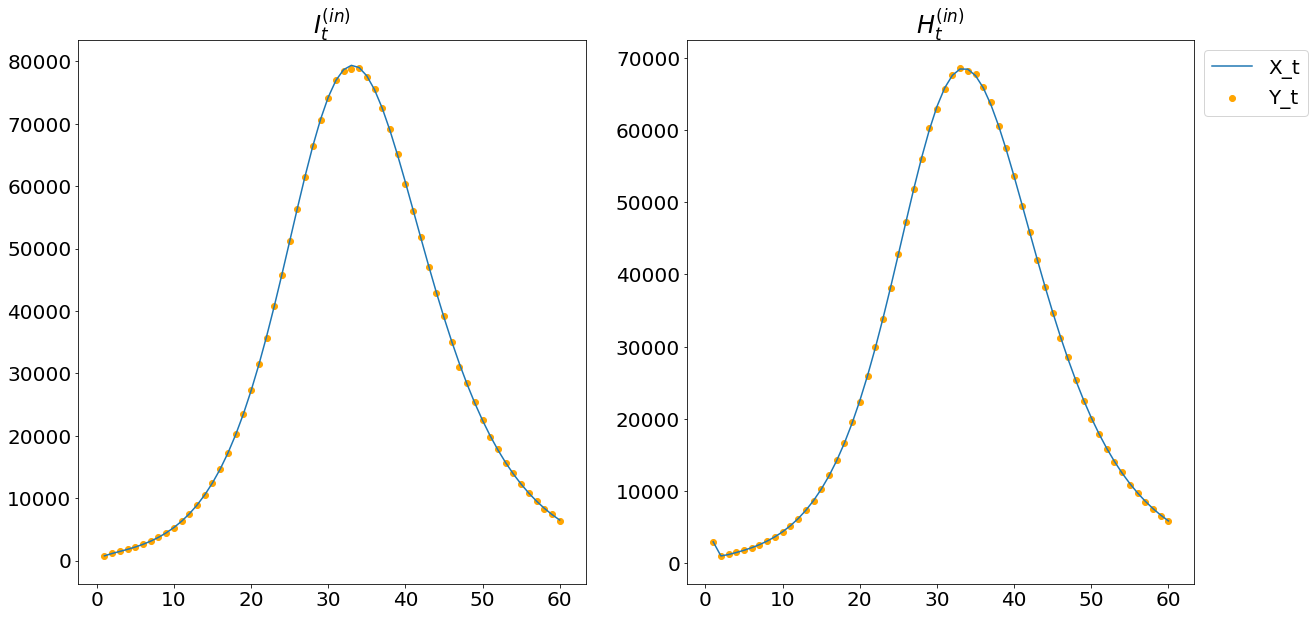

In [2]:
n_deriv = [1]*6 # number of derivatives in IVP
n_deriv_prior = [3]*6 # number of derivatives in IBM prior
state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0
tmax = 60

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 6
sigma = [.1]*n_var

# Initial value, x0, for the IVP
theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 0.36, 30]) # True theta
x0 = np.array([63804435, 15492, 21752, 618013, 93583, 0])
v0 = seirah(x0, 0, theta_true)
X0 = np.ravel([x0, v0], 'F')

# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

# logprior parameters
n_theta = len(theta_true)
phi_sd = np.ones(n_theta)

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, seirah)
Y_t, X_t = inf.simulatep(seirah, x0, theta_true)

# Plot observations and true value
tseq = np.linspace(1, tmax, tmax-tmin)
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(tseq,  X_t[:,0], label = 'X_t')
axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
axs[0].set_title("$I^{(in)}_t$")
axs[1].plot(tseq, X_t[:,1], label = 'X_t')
axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
axs[1].set_title("$H^{(in)}_t$")
axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])

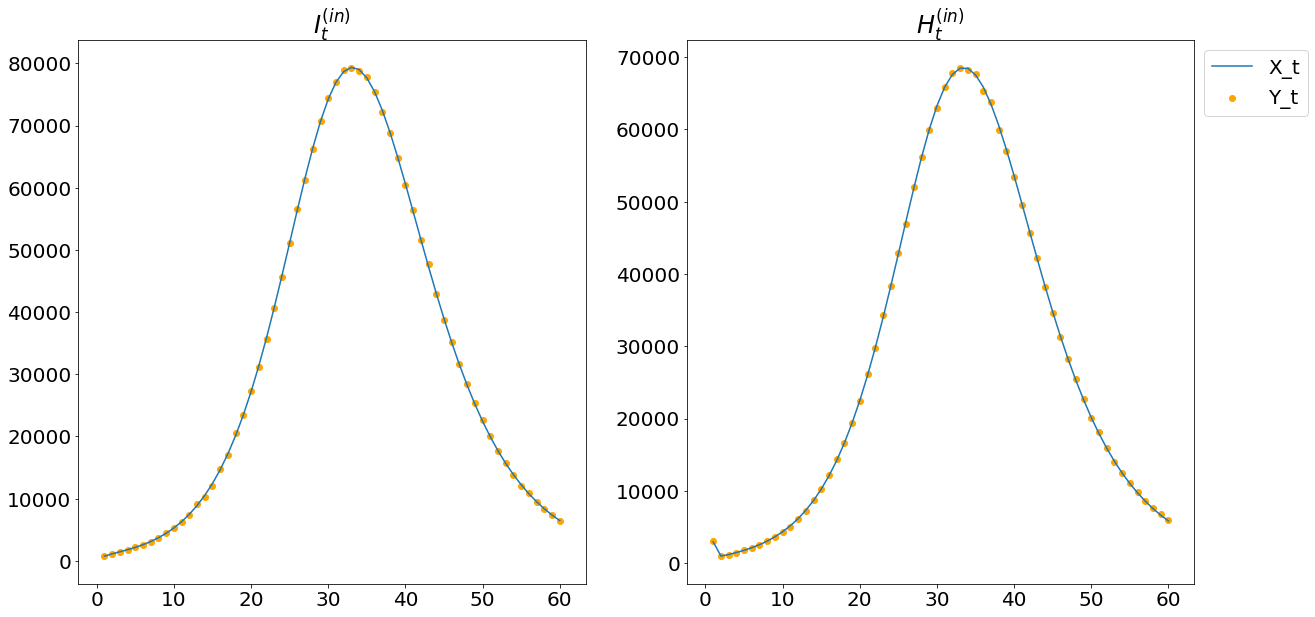

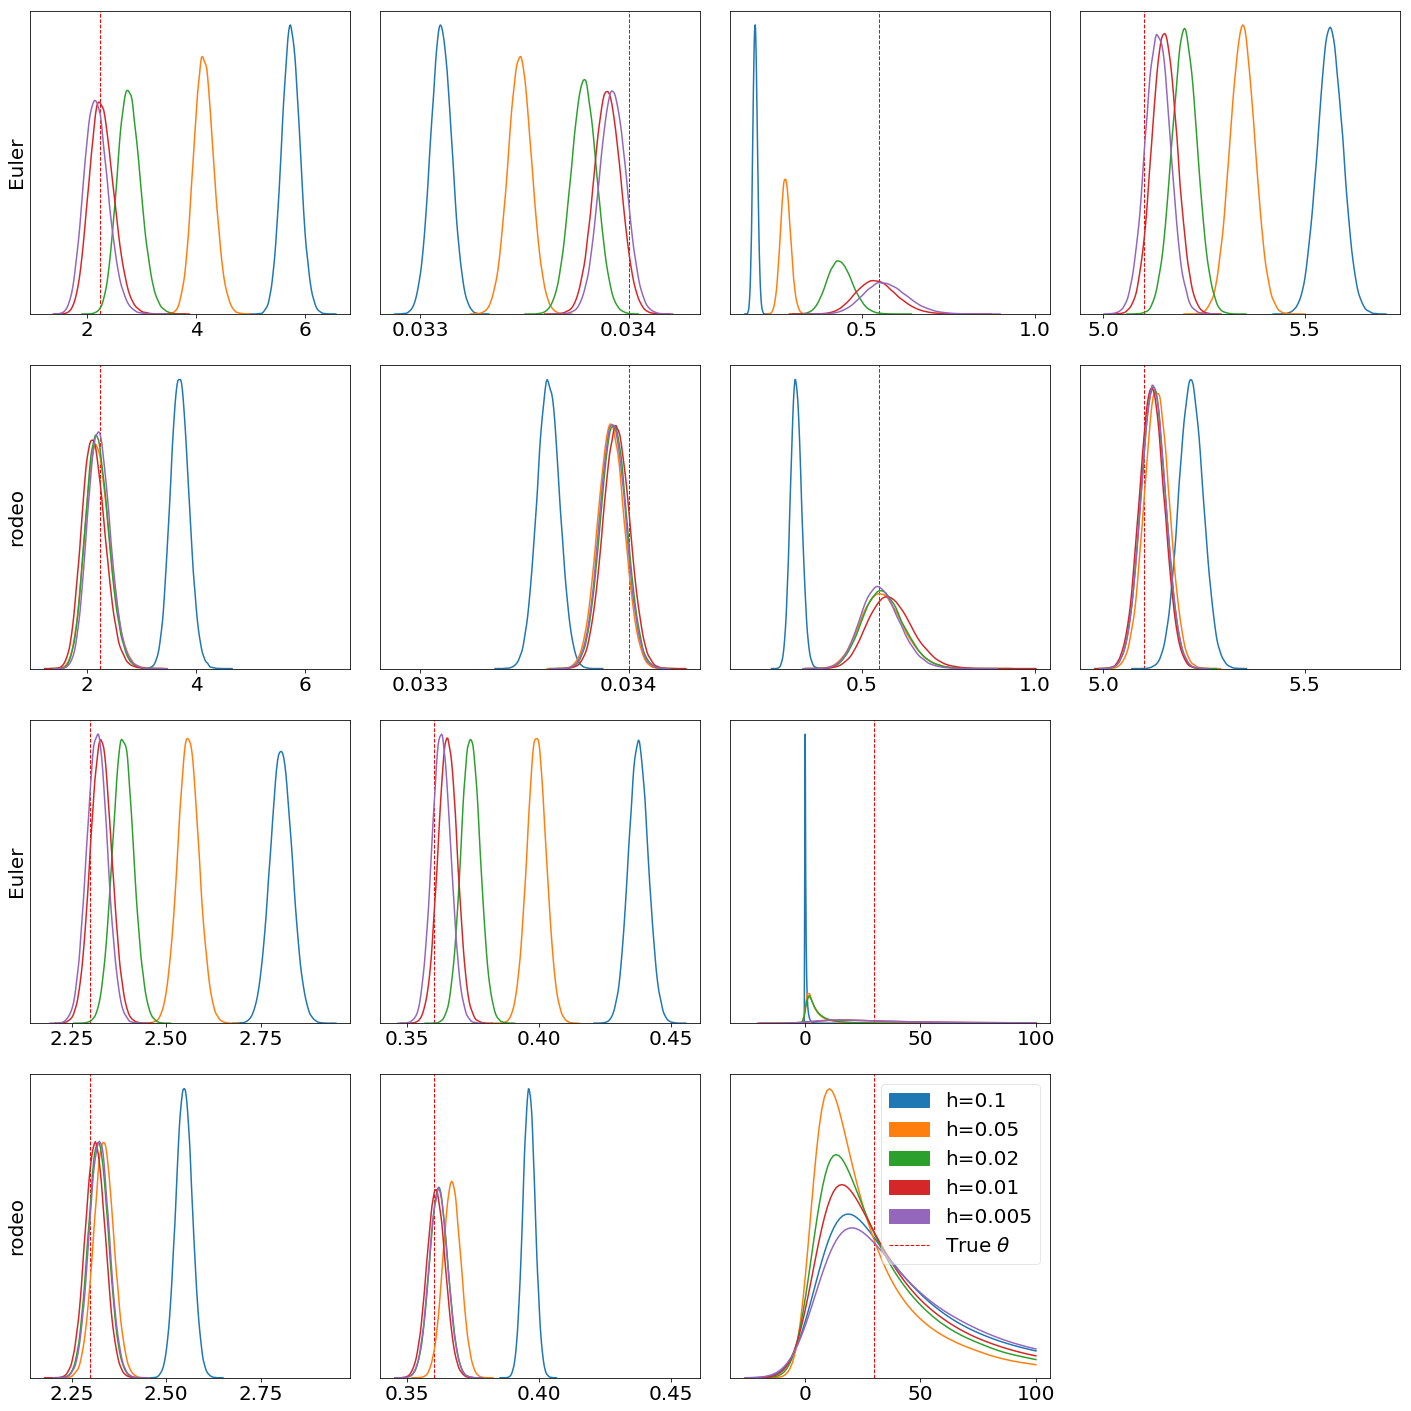

In [2]:
import numpy as np
from inference import inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def seirah(X_t, t, theta, x_out=None):
    "SEIRAH ODE function"
    if x_out is None:
        x_out = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q, D_h = theta
    x_out[0] = -b*S*(I + alpha*A)/N
    x_out[1] = b*S*(I + alpha*A)/N - E/D_e
    x_out[2] = r*E/D_e - I/D_q - I/D_0I
    x_out[3] = (I + A)/D_I + H/D_h
    x_out[4] = (1-r)*E/D_e - A/D_I
    x_out[5] = I/D_q - H/D_h
    return x_out

def seirah_example(load_calcs=False):
    n_deriv = [1]*6 # number of derivatives in IVP
    n_deriv_prior = [3]*6 # number of derivatives in IBM prior
    state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0
    tmax = 60

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    n_var = 6
    sigma = [.5]*n_var

    # Initial value, x0, for the IVP
    theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 0.36, 30]) # True theta
    x0 = np.array([63804435, 15492, 21752, 618013, 93583, 0])
    v0 = seirah(x0, 0, theta_true)
    X0 = np.ravel([x0, v0], 'F')

    # W matrix: dimension is n_eq x sum(n_deriv)
    W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
    for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
    W = zero_pad(W_mat, n_deriv, n_deriv_prior)

    # logprior parameters
    n_theta = len(theta_true)
    phi_sd = np.ones(n_theta)

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    inf = inference(state_ind, tmin, tmax, seirah)
    Y_t, X_t = inf.simulatep(seirah, x0, theta_true)

    # Plot observations and true value
    tseq = np.linspace(1, tmax, tmax-tmin)
    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].plot(tseq,  X_t[:,0], label = 'X_t')
    axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
    axs[0].set_title("$I^{(in)}_t$")
    axs[1].plot(tseq, X_t[:,1], label = 'X_t')
    axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
    axs[1].set_title("$H^{(in)}_t$")
    axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])
    fig.savefig('figures/seirahsim2.pdf')

    hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
    if load_calcs:
        theta_euler = np.load('saves/seirah_theta_euler1.npy')
        theta_kalman = np.load('saves/seirah_theta_kalman1.npy')
    else:
        theta_euler = np.zeros((len(hlst), n_samples, n_theta))
        for i in range(len(hlst)):
            phi_hat, phi_var = inf.phi_fitp(Y_t, x0, hlst[i], theta_true, phi_sd, False)
            theta_euler[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
        np.save('saves/seirah_theta_euler1.npy', theta_euler)
        
        # Parameter inference using Kalman solver
        theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
        for i in range(len(hlst)):
            ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
            x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
            kinit = indep_init(ode_init, n_deriv_prior)
            n_eval = int((tmax-tmin)/hlst[i])
            kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)
            inf.kode = kode
            inf.W = W
            phi_hat, phi_var = inf.phi_fitp(Y_t, x0_state, hlst[i], theta_true, phi_sd, True)
            theta_kalman[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
        np.save('saves/seirah_theta_kalman1.npy', theta_kalman)
    
    plt.rcParams.update({'font.size': 20})
    clip = [None]*6 + [(-30, 100)]
    figure = inf.theta_plot(theta_euler, theta_kalman, theta_true, hlst, clip=clip, rows=2)
    figure.savefig('figures/seirahfigure2.pdf')
    plt.show()
    return

if __name__ == '__main__':
    seirah_example(True)
